In [1]:
import autograd

import autograd.numpy as np
import autograd.scipy as sp
from numpy.polynomial.hermite import hermgauss

from vb_lib import structure_model_lib, data_utils, cavi_lib
import vb_lib.structure_optimization_lib as str_opt_lib

import paragami
import vittles

from copy import deepcopy

import argparse
import distutils.util

import os

import time

import matplotlib.pyplot as plt
%matplotlib inline  

from bnpmodeling_runjingdev import cluster_quantities_lib, modeling_lib


/home/rliu/anaconda3/envs/bnp_sensitivity/lib/python3.8/site-packages/autograd/core.py:290: UserWarning: 
The defvjp method is deprecated. See the update guide and tutorial:
https://github.com/HIPS/autograd/blob/master/docs/updateguide.md
https://github.com/HIPS/autograd/blob/master/docs/tutorial.md
  warnings.warn(deprecation_msg)


In [2]:
np.random.seed(53453)

# Draw data

In [3]:
n_obs = 50
n_loci = 40
n_pop = 4

In [4]:
g_obs, true_pop_allele_freq, true_ind_admix_propn = \
    data_utils.draw_data(n_obs, n_loci, n_pop)

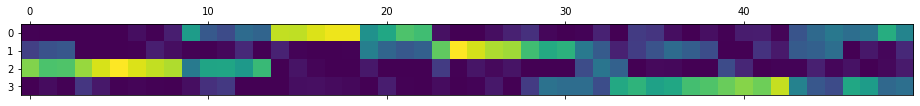

In [5]:
plt.matshow(true_ind_admix_propn.T)

In [6]:
g_obs.shape

(50, 40, 3)

# Get prior

In [7]:
prior_params_dict, prior_params_paragami = \
    structure_model_lib.get_default_prior_params()

print(prior_params_paragami)

prior_params_free = prior_params_paragami.flatten(prior_params_dict, free = True)

OrderedDict:
	[dp_prior_alpha] = NumericArrayPattern (1,) (lb=0.0, ub=inf)
	[allele_prior_alpha] = NumericArrayPattern (1,) (lb=0.0, ub=inf)
	[allele_prior_beta] = NumericArrayPattern (1,) (lb=0.0, ub=inf)


# Get VB params 

In [8]:
k_approx = 12

In [9]:
gh_deg = 8
gh_loc, gh_weights = hermgauss(8)

In [10]:
use_logitnormal_sticks = False

vb_params_dict, vb_params_paragami = \
    structure_model_lib.get_vb_params_paragami_object(n_obs, n_loci, k_approx,
                                    use_logitnormal_sticks = use_logitnormal_sticks)
    
print(vb_params_paragami)

OrderedDict:
	[pop_freq_beta_params] = NumericArrayPattern (40, 12, 2) (lb=0.0, ub=inf)
	[ind_mix_stick_beta_params] = NumericArrayPattern (50, 11, 2) (lb=0.0, ub=inf)


## Initialize 

In [11]:
vb_params_dict = \
        structure_model_lib.set_init_vb_params(g_obs, k_approx, vb_params_dict,
                                                use_logitnormal_sticks)

In [12]:
def get_vb_expectations(vb_params_dict, use_logitnormal_sticks): 
    if use_logitnormal_sticks: 
        e_ind_admix = cluster_quantities_lib.get_e_cluster_probabilities(
                            vb_opt_dict['ind_mix_stick_propn_mean'], 
                            vb_opt_dict['ind_mix_stick_propn_info'],
                            gh_loc, gh_weights)

    else: 
        ind_mix_stick_beta_params = vb_params_dict['ind_mix_stick_beta_params']
        e_stick_lengths = \
                modeling_lib.get_e_beta(ind_mix_stick_beta_params)
        e_ind_admix = cluster_quantities_lib.get_mixture_weights_from_stick_break_propns(e_stick_lengths)

    e_pop_freq = modeling_lib.get_e_beta(vb_params_dict['pop_freq_beta_params'])
    
    return e_ind_admix, e_pop_freq

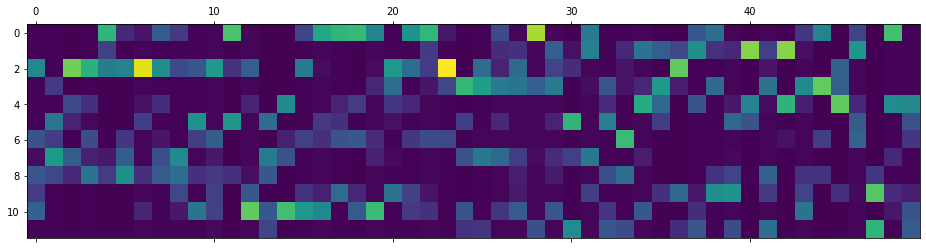

In [13]:
plt.matshow(get_vb_expectations(vb_params_dict, use_logitnormal_sticks)[0].transpose())

# Run CAVI

In [14]:
# get beta parameters for sticks and populations
ez_opt, vb_opt_dict = \
    cavi_lib.run_cavi(g_obs, vb_params_dict, 
                        prior_params_dict,
                        use_logitnormal_sticks, 
                        max_iter = 1000,
                        f_tol = 1e-4)


iteration [0]; kl:5808.827066
iteration [1]; kl:4566.250954
iteration [2]; kl:4330.351941
iteration [3]; kl:4267.947915
iteration [4]; kl:4229.534239
iteration [5]; kl:4196.291868
iteration [6]; kl:4164.797523
iteration [7]; kl:4133.915619
iteration [8]; kl:4103.219158
iteration [9]; kl:4072.657477
iteration [10]; kl:4042.420864
iteration [11]; kl:4012.842137
iteration [12]; kl:3984.336632
iteration [13]; kl:3957.364863
iteration [14]; kl:3932.400452
iteration [15]; kl:3909.887328
iteration [16]; kl:3890.036242
iteration [17]; kl:3872.651069
iteration [18]; kl:3857.274965
iteration [19]; kl:3843.455136
iteration [20]; kl:3830.844107
iteration [21]; kl:3819.181734
iteration [22]; kl:3808.262359
iteration [23]; kl:3797.915121
iteration [24]; kl:3788.021276
iteration [25]; kl:3778.565098
iteration [26]; kl:3769.667977
iteration [27]; kl:3761.540409
iteration [28]; kl:3754.329744
iteration [29]; kl:3747.977428
iteration [30]; kl:3742.263631
iteration [31]; kl:3736.993212
iteration [32]; kl

In [15]:
vb_opt = vb_params_paragami.flatten(vb_opt_dict, free = True)

In [16]:
objective = paragami.FlattenFunctionInput(original_fun=structure_model_lib.get_kl, 
                                    patterns = [vb_params_paragami, prior_params_paragami],
                                    free = True,
                                    argnums = [1, 2])

objective_fun = lambda x, y: objective(g_obs, x, y, use_logitnormal_sticks = False)


In [17]:
import scipy as osp

In [18]:
continue_with_newton = False

if continue_with_newton: 
    
    get_loss = lambda x : objective_fun(x, prior_params_free)
    get_loss_objective = paragami.OptimizationObjective(get_loss)
    
    res = osp.optimize.minimize(
                fun=get_loss_objective.f,
                jac=get_loss_objective.grad,
                hess=get_loss_objective.hessian,
                x0=vb_params_paragami.flatten(vb_params_dict, free = True),
                method='trust-exact', options={'disp':True})
    
    
    print('\nlinf diff in vb_params: ', np.abs(res.x - vb_opt).max())
    
    vb_opt = deepcopy(res.x)
    vb_opt_dict = vb_params_paragami.fold(vb_opt, free = True)
    ez_opt = str_opt_lib.get_e_z_from_vb_params_dict(g_obs, vb_opt_dict, use_logitnormal_sticks)


# Check results

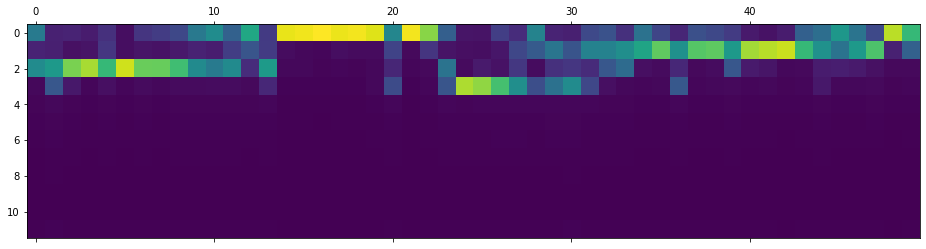

In [19]:
plt.matshow(get_vb_expectations(vb_opt_dict, use_logitnormal_sticks)[0].transpose())

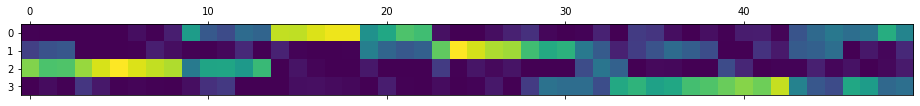

In [20]:
plt.matshow(true_ind_admix_propn.transpose())

# Check optimum

In [25]:
# get hessian 
t0 = time.time()
# get_hess = autograd.hessian(objective_fun, argnum = 0)
# hessian_at_opt = get_hess(vb_opt, prior_params_free)

#  print('hessian time: {}sec'.format(np.round(time.time() - t0, 3)))
# hess_solver = vittles.solver_lib.get_cholesky_solver(hessian_at_opt)

objective_fun_hvp = autograd.hessian_vector_product(objective_fun, argnum = 0)
hess_solver = vittles.solver_lib.get_cg_solver(lambda x : objective_fun_hvp(vb_opt, prior_params_free, x),
                                 dim = len(vb_opt))

In [26]:
# gradient 
get_objective_grad = autograd.jacobian(objective_fun, argnum = 0)

In [27]:
optimum_checker = vittles.bivariate_sensitivity_lib.OptimumChecker(
                                                estimating_equation = get_objective_grad, 
                                                solver = hess_solver, 
                                                input_base = vb_opt, 
                                                hyper_base = prior_params_free)


/home/rliu/anaconda3/envs/bnp_sensitivity/lib/python3.8/site-packages/vittles/bivariate_sensitivity_lib.py:32: UserWarning: The CrossSensitivity class is very experimental and untested.
  warnings.warn(


In [28]:
newton_step = optimum_checker.get_newton_step()

In [29]:
np.abs(newton_step).max()

0.07647901179275465

# Parametric sensitivity

### Hyper parameter sensitivity object

In [39]:
# vb_sens = \
#     vittles.HyperparameterSensitivityLinearApproximation(
#         objective_fun = objective_fun, 
#         opt_par_value = vb_opt, 
#         hyper_par_value = prior_params_free, 
#         hessian_at_opt = hessian_at_opt)

vb_sens = \
    vittles.ParametricSensitivityTaylorExpansion(
        estimating_equation = get_objective_grad, 
        input_val0 = vb_opt, 
        hyper_val0 = prior_params_free, 
        order = 1, 
        hess_solver = hess_solver)


### Set new prior

In [40]:
new_alpha = np.array([4.])

prior_params_pert_dict = deepcopy(prior_params_dict)
prior_params_pert_dict['dp_prior_alpha'] = new_alpha


In [41]:
print('initial alpha, ', prior_params_dict['dp_prior_alpha'])
print('perturbed alpha, ', prior_params_pert_dict['dp_prior_alpha'])

initial alpha,  [3.]
perturbed alpha,  [4.]


In [42]:
# lr_vb_free_params = \
#     vb_sens.predict_opt_par_from_hyper_par(
#         prior_params_paragami.flatten(prior_params_pert_dict, free = True))

lr_vb_free_params = \
    vb_sens.evaluate_taylor_series(
        prior_params_paragami.flatten(prior_params_pert_dict, free = True))

In [43]:
print('l_inf diff: ', np.max(np.abs(lr_vb_free_params - vb_opt)))


l_inf diff:  0.6653037145834191


In [44]:
vb_opt

array([3.31581665, 2.30432607, 2.55130716, ..., 1.18613212, 0.04717559,
       1.17126954])

In [45]:
lr_vb_free_params

array([3.28382147, 2.21766596, 2.54376835, ..., 1.55835301, 0.09200184,
       1.53449856])

### Re-optimize

In [46]:
new_init_dict = deepcopy(vb_opt_dict)
# new_init_dict = deepcopy(init_vb_params_dict)
new_init_free = vb_params_paragami.flatten(new_init_dict, free = True)


In [47]:
# get beta parameters for sticks and populations
ez_pert, vb_pert_dict = \
    cavi_lib.run_cavi(g_obs, new_init_dict, 
                        prior_params_pert_dict,
                        use_logitnormal_sticks, 
                        max_iter = 1000,
                        f_tol = 1e-4)


iteration [0]; kl:3918.762767
iteration [1]; kl:3910.834645
iteration [2]; kl:3908.710374
iteration [3]; kl:3907.865687
iteration [4]; kl:3907.459554
iteration [5]; kl:3907.23779
iteration [6]; kl:3907.104167
iteration [7]; kl:3907.016851
iteration [8]; kl:3906.955792
iteration [9]; kl:3906.910626
iteration [10]; kl:3906.875652
iteration [11]; kl:3906.847565
iteration [12]; kl:3906.824353
iteration [13]; kl:3906.804737
iteration [14]; kl:3906.787872
iteration [15]; kl:3906.773179
iteration [16]; kl:3906.760247
iteration [17]; kl:3906.748773
iteration [18]; kl:3906.738529
iteration [19]; kl:3906.729339
iteration [20]; kl:3906.72106
iteration [21]; kl:3906.713581
iteration [22]; kl:3906.706805
iteration [23]; kl:3906.700654
iteration [24]; kl:3906.69506
iteration [25]; kl:3906.689965
iteration [26]; kl:3906.68532
iteration [27]; kl:3906.681079
iteration [28]; kl:3906.677204
iteration [29]; kl:3906.67366
iteration [30]; kl:3906.670417
iteration [31]; kl:3906.667448
iteration [32]; kl:3906

In [48]:
vb_opt_pert = vb_params_paragami.flatten(vb_pert_dict, free = True)

### Compare lr vs reoptimizing

In [49]:
def print_diff_plot(lr_vb_free_params, vb_opt_pert, vb_opt): 
    plt.plot(lr_vb_free_params - vb_opt, 
             vb_opt_pert - vb_opt, 
             '+', color = 'red')

    plt.plot(lr_vb_free_params - vb_opt, 
            lr_vb_free_params - vb_opt, 
             '-', color = 'blue')

    plt.xlabel('lr')
    plt.ylabel('re-optimized')


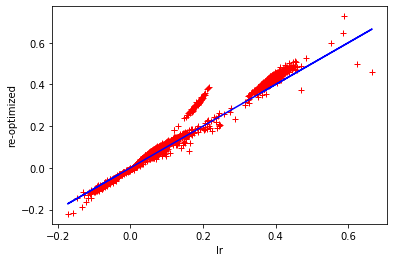

In [50]:
print_diff_plot(lr_vb_free_params, vb_opt_pert, vb_opt)

In [51]:
objective_fun(lr_vb_free_params, prior_params_paragami.flatten(prior_params_pert_dict, free = True))

3906.9562413321937

In [52]:
objective_fun(vb_opt_pert, prior_params_paragami.flatten(prior_params_pert_dict, free = True))

3906.6345322583543

# Fit for a range of alpha

In [53]:
alpha_list = np.arange(1, 15)

In [54]:
def refit_with_alpha(alpha, new_init_dict):
    # sets new alpha, returns new vb optimum
    
    # set new prior
    new_alpha = np.array([alpha])

    prior_params_pert_dict = deepcopy(prior_params_dict)
    prior_params_pert_dict['dp_prior_alpha'] = new_alpha

    # get beta parameters for sticks and populations
    ez_pert, vb_pert_dict = \
        cavi_lib.run_cavi(g_obs, new_init_dict, 
                            prior_params_pert_dict,
                            use_logitnormal_sticks, 
                            max_iter = 1000,
                            f_tol = 1e-4, 
                             print_every = 1e16)

    vb_opt_pert = vb_params_paragami.flatten(vb_pert_dict, free = True)   
        
    return vb_opt_pert


In [55]:
vb_pert_list = []
for alpha in alpha_list: 
    print('\nre-optimzing with alpha = ', alpha)
    
    vb_pert_list.append(refit_with_alpha(alpha, new_init_dict))



re-optimzing with alpha =  1
iteration [0]; kl:2975.316444
CAVI done. Termination after 290 steps in 3.72 seconds

re-optimzing with alpha =  2
iteration [0]; kl:3360.621939
CAVI done. Termination after 403 steps in 5.74 seconds

re-optimzing with alpha =  3
iteration [0]; kl:3662.541781
CAVI done. Termination after 1 steps in 0.03 seconds

re-optimzing with alpha =  4
iteration [0]; kl:3918.762767
CAVI done. Termination after 73 steps in 1.03 seconds

re-optimzing with alpha =  5
iteration [0]; kl:4144.99055
CAVI done. Termination after 80 steps in 1.12 seconds

re-optimzing with alpha =  6
iteration [0]; kl:4349.541113
CAVI done. Termination after 311 steps in 4.22 seconds

re-optimzing with alpha =  7
iteration [0]; kl:4537.446007
CAVI done. Termination after 710 steps in 9.73 seconds

re-optimzing with alpha =  8
iteration [0]; kl:4712.024738
CAVI done. Termination after 607 steps in 7.96 seconds

re-optimzing with alpha =  9
iteration [0]; kl:4875.605231
CAVI done. Termination af

In [ ]:
vb_sens

In [56]:
lr_list = []

for alpha in alpha_list: 
    
    # set alpha 
    new_alpha = np.array([alpha])
    prior_params_pert_dict = deepcopy(prior_params_dict)
    prior_params_pert_dict['dp_prior_alpha'] = new_alpha
    
    # get linear response
#     lr_list.append(vb_sens.predict_opt_par_from_hyper_par(
#         prior_params_paragami.flatten(prior_params_pert_dict, free = True)))
    
    lr_list.append(vb_sens.evaluate_taylor_series(
        prior_params_paragami.flatten(prior_params_pert_dict, free = True)))

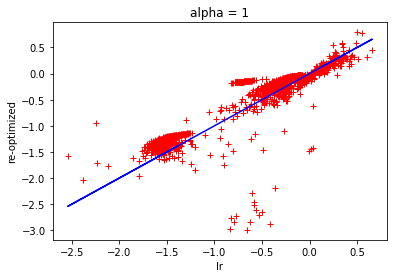

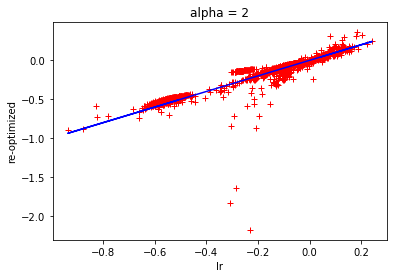

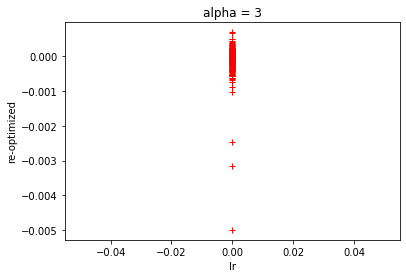

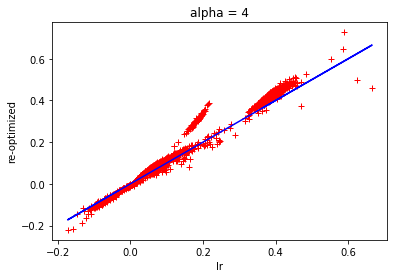

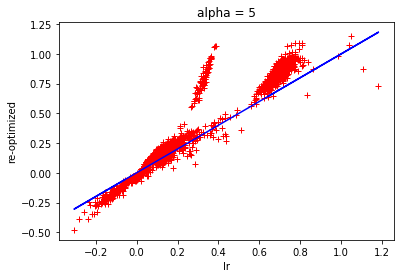

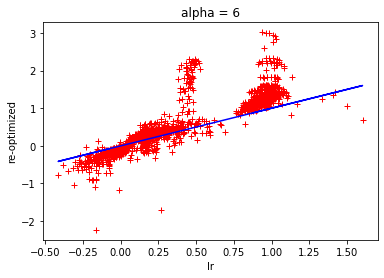

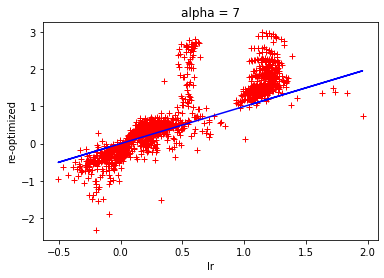

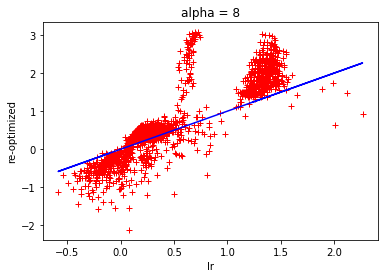

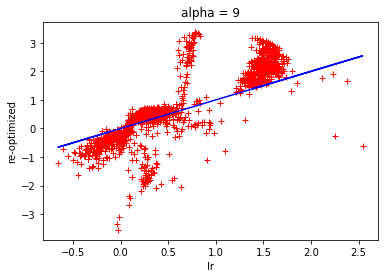

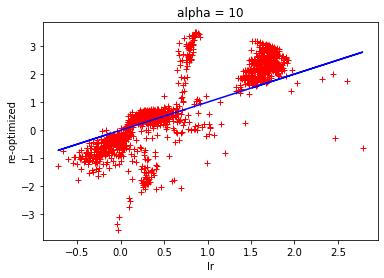

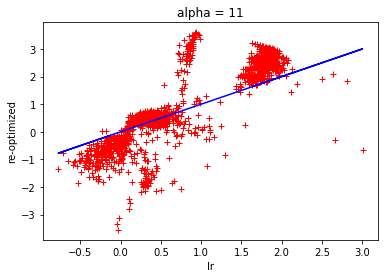

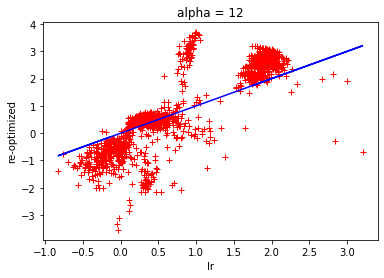

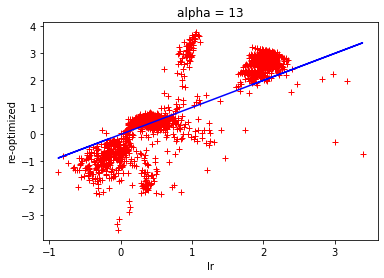

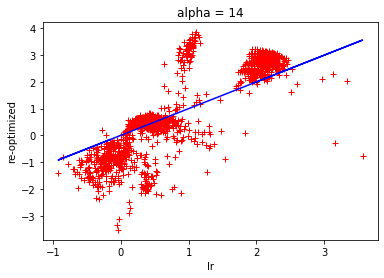

In [57]:
for i in range(len(alpha_list)): 
    plt.figure()
    print_diff_plot(lr_list[i], vb_pert_list[i], vb_opt)
    
    plt.title('alpha = {}'.format(alpha_list[i]))


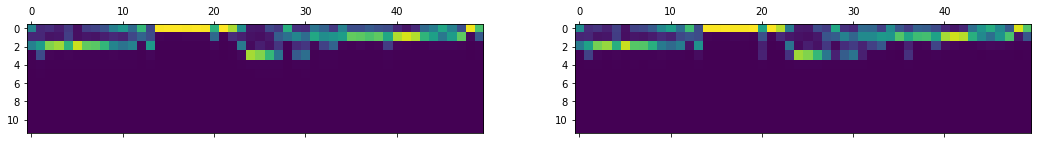

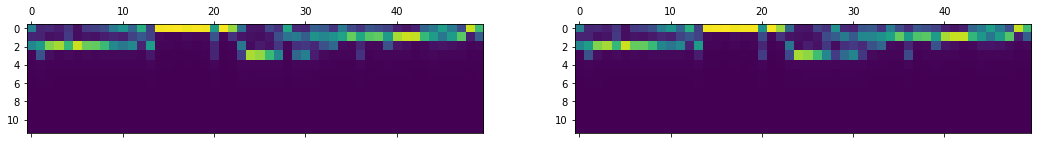

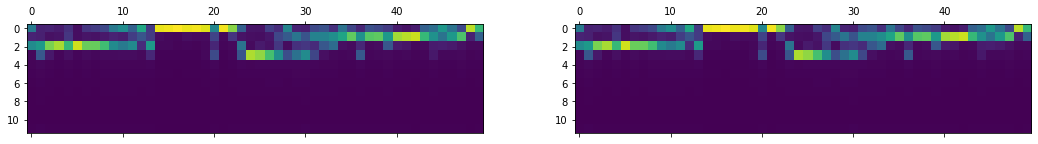

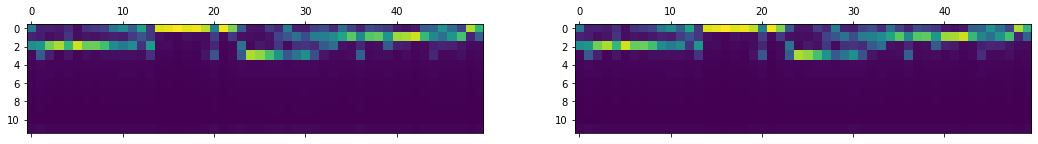

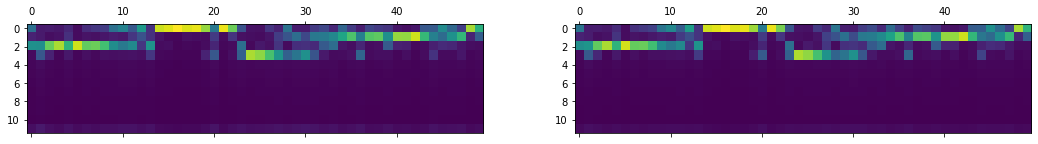

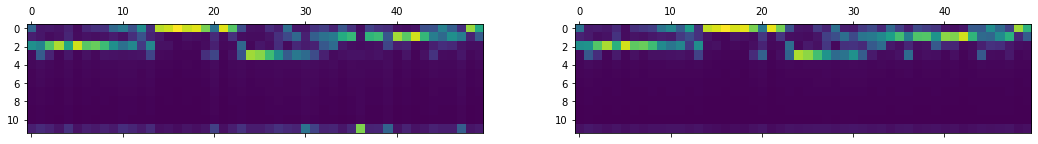

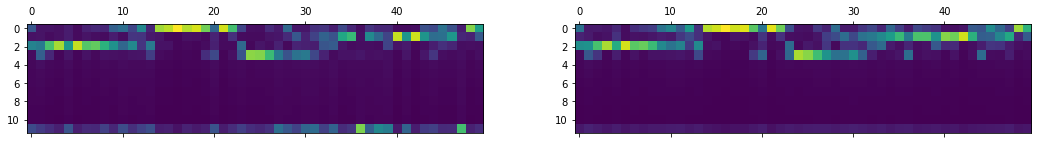

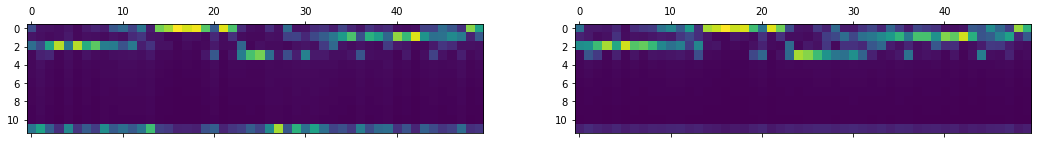

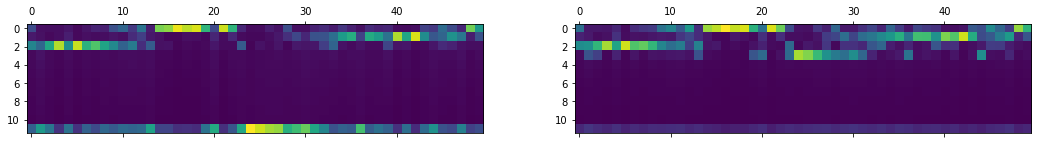

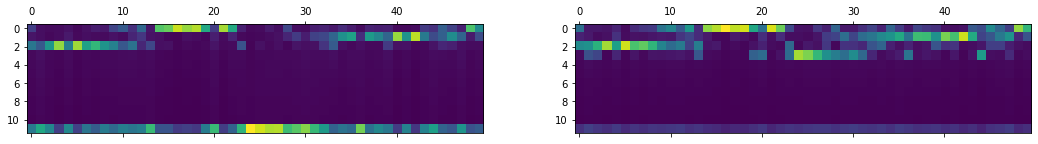

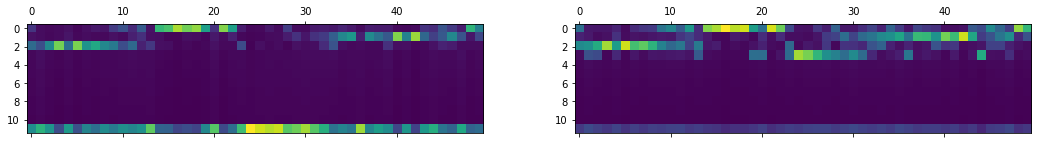

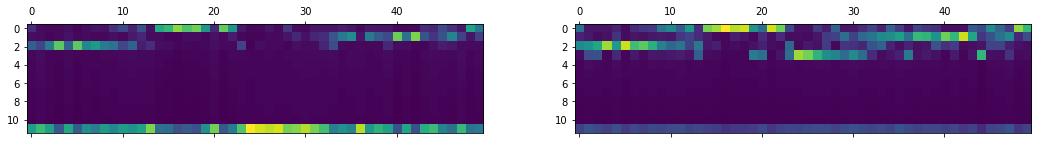

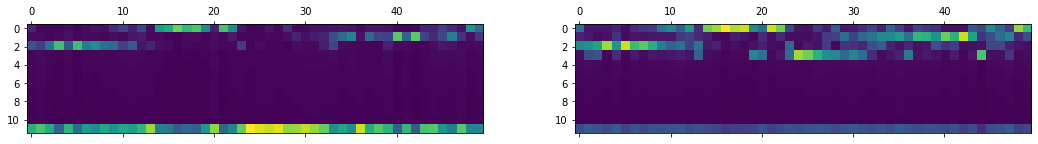

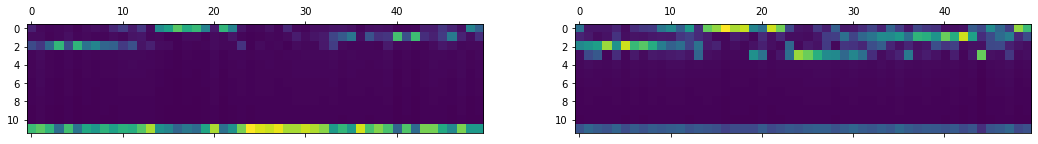

In [58]:
for i in range(len(alpha_list)): 

    fig, axes = plt.subplots(1, 2, figsize = (18, 4))

    lr_dict = vb_params_paragami.fold(lr_list[i], free = True)
    pert_dict = vb_params_paragami.fold(vb_pert_list[i], free = True)
    
    axes[0].matshow(get_vb_expectations(pert_dict, use_logitnormal_sticks)[0].transpose())
    axes[1].matshow(get_vb_expectations(lr_dict, use_logitnormal_sticks)[0].transpose())


### Examine expected number of clusters

In [59]:
n_samples = 10000
unif_samples = np.random.random((n_obs, n_samples))

threshold = 0

In [60]:
e_num_clusters_lr = np.zeros(len(alpha_list))
e_num_clusters_pert = np.zeros(len(alpha_list))

for i in range(len(alpha_list)): 
    lr_dict = vb_params_paragami.fold(lr_list[i], free = True)
    pert_dict = vb_params_paragami.fold(vb_pert_list[i], free = True)

    # these are individual belongings
    pert_e_ind_admix, _ = get_vb_expectations(pert_dict, use_logitnormal_sticks)
    
    lr_e_ind_admix, _ = get_vb_expectations(lr_dict, use_logitnormal_sticks)
    
    # get expected number of clusters
    
    # this isn't quite right : we are treating the individual admixtures like multinomial probabilities, 
    # not a stick-breaking process
    e_num_clusters_lr[i] = cluster_quantities_lib.get_e_num_large_clusters_from_ez(lr_e_ind_admix,
                                threshold,
                                unif_samples = unif_samples)[0]
    
    e_num_clusters_pert[i] = cluster_quantities_lib.get_e_num_large_clusters_from_ez(pert_e_ind_admix,
                                threshold,
                                unif_samples = unif_samples)[0]

In [61]:
lr_e_ind_admix.shape

(50, 12)

Text(0, 0.5, 'expected number of clusters')

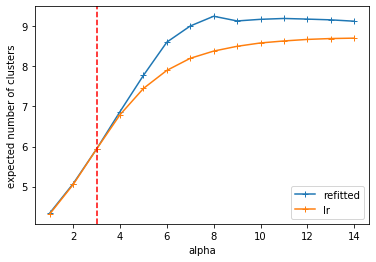

In [62]:
plt.plot(alpha_list, e_num_clusters_pert, '+-')
plt.plot(alpha_list, e_num_clusters_lr, '+-')

plt.axvline(x = prior_params_dict['dp_prior_alpha'], linestyle = '--', color = 'r')

plt.legend(('refitted', 'lr'))

plt.xlabel('alpha')
plt.ylabel('expected number of clusters')